# Pairwise disorder comparison between effectors and  reference proteomes - IUPRed long

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob


import sys
sys.path.append('../src/')

import aepathdisorder

%matplotlib inline

In [2]:
# Load maps
bug_map = aepathdisorder.load_map('../data/maps/reference_taxa.json')
CR_map = aepathdisorder.load_map('../data/maps/CR_taxa.json')
EHEC_map = aepathdisorder.load_map('../data/maps/EHEC_taxa.json')
EPEC_map = aepathdisorder.load_map('../data/maps/EPEC_taxa.json')

# Load IUPRed long aggregated results
bug_cat_long = glob.glob('../data/iupred_aggregated_disfrac-class/proteomes/*long*.table')
EHEC_cat_long = glob.glob('../data/iupred_aggregated_disfrac-class/EHEC_effectors/*long*.table')
EPEC_cat_long = glob.glob('../data/iupred_aggregated_disfrac-class/EPEC_effectors/*long*.table')
CR_cat_long = glob.glob('../data/iupred_aggregated_disfrac-class/CR_effectors/*long*.table')
human_cat_long = glob.glob('../data/iupred_aggregated_disfrac-class/human_proteome/*long*.table')

In [3]:
def concatenate_results(path_list):

    dflist = []
    for path in path_list:
        tmpdf = pd.read_csv(filepath_or_buffer=path,
                            header=0, index_col=0, sep='\t')
        dflist.append(tmpdf)
    df = pd.concat(dflist)
    return df
    

In [4]:
human_df = concatenate_results(human_cat_long)
bug_df = concatenate_results(bug_cat_long)
EHEC_df = concatenate_results(EHEC_cat_long)
EPEC_df = concatenate_results(EPEC_cat_long)
CR_df = concatenate_results(CR_cat_long)

effector_types = ['EHEC', 'EPEC', 'CR']
effector_dfs = [EHEC_df, EPEC_df, CR_df]
effector_maps = [EHEC_map, EPEC_map, CR_map]

for df, mapdict in zip(effector_dfs, effector_maps):
    df['dataset'] = df['protein_ac'].map(mapdict)
    df['collection_type'] = 'Effector'

for df, effector_type in zip(effector_dfs, effector_types):
    df['effector_type'] = effector_type
# Make bug taxa strings (stored as int)
bug_df['dataset'] = bug_df['dataset'].astype(str)
# Define references as such
bug_df['collection_type'] = 'Reference'

merged_effector_df = pd.concat(effector_dfs)


In [5]:
bug_efftype_map = {}
for k, v in bug_map.items():
    bug_efftype_map[k] = v['type']

bug_efftype_map

{'244319': 'EHEC',
 '362663': 'UPEC',
 '574521': 'EPEC',
 '585395': 'EHEC',
 '585396': 'EHEC',
 '637910': 'CR',
 '83334': 'EHEC'}

In [6]:
effector_taxa  = set(merged_effector_df['dataset'])
reference_taxa = set(bug_df['dataset'])

paired_taxa = effector_taxa & reference_taxa

paired_effectors = merged_effector_df[merged_effector_df['dataset'].isin(paired_taxa)]
paired_bugs = bug_df[bug_df['dataset'].isin(paired_taxa)]

In [7]:
paired_bugs['effector_type'] = paired_bugs['dataset'].map(bug_efftype_map) 

In [8]:
final_df = pd.concat([paired_effectors, paired_bugs], ignore_index=True)
final_df.reset_index(inplace=True)
# Drop effectors from Reference collections
final_df = final_df.sort_values(by='collection_type').drop_duplicates(subset='protein_ac')

In [9]:
final_df.sample(10)

,index,protein_ac,dataset,disorder_predictor,disorder_fraction,disorder_category,collection_type,effector_type
11488,11488,B7UJS6,574521,iupred-long,0.221053,PDR,Reference,EPEC
9829,9829,D2TV35,637910,iupred-long,0.000000,ORD,Reference,CR
7242,7242,D2TMG6,637910,iupred-long,0.000000,ORD,Reference,CR
2196,2196,P63202,83334,iupred-long,0.000000,ORD,Reference,EHEC
14039,14039,B7US89,574521,iupred-long,0.258065,NDP,Reference,EPEC
1472,1472,P0A9Y8,83334,iupred-long,0.000000,ORD,Reference,EHEC
12187,12187,B7ULT7,574521,iupred-long,0.048276,ORD,Reference,EPEC
303,303,A0A0H3JEC0,83334,iupred-long,0.020101,ORD,Reference,EHEC
12519,12519,B7UMS5,574521,iupred-long,0.000000,ORD,Reference,EPEC
8709,8709,D2TRS4,637910,iupred-long,0.000000,ORD,Reference,CR


In [10]:
import seaborn as sns

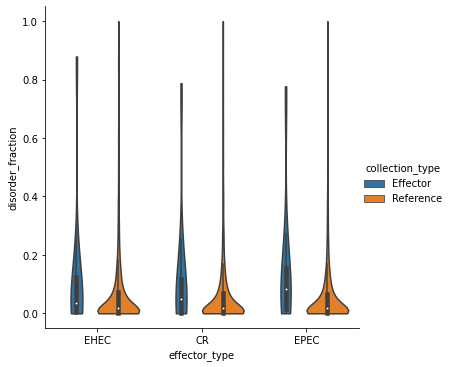

In [11]:
sns.catplot(
    x='effector_type',
    y='disorder_fraction',
    hue='collection_type',
    data=final_df,
    kind='violin',
    cut=0)

plt.savefig('../figures/pairwise_iupred-long.png',
            dpi=300)

In [12]:
from scipy.stats import mannwhitneyu

In [13]:
print('Group\tp-value')
for gp, df in final_df.groupby('effector_type'):
    ref = df[df['collection_type']=='Reference']['disorder_fraction']
    eff = df[df['collection_type']=='Effector']['disorder_fraction']
    stat, pval = mannwhitneyu(x=ref, y=eff, alternative='less')
    print(gp, '\t', f'{pval:0.5f}')

Group	p-value
CR 	 0.06500
EHEC 	 0.06272
EPEC 	 0.00063


In [14]:
for taxon in paired_taxa:
    print(taxon, bug_map[taxon])

83334 {'name': 'E. coli O157:H7', 'type': 'EHEC', 'uniprot_reference': 'UP000000558', 'PAI': ['NC_002695_P2', 'NC_002655_P5']}
574521 {'name': 'E. coli O127:H6', 'type': 'EPEC', 'uniprot_reference': 'UP000008205', 'PAI': ['AF022236']}
637910 {'name': 'Citrobacter rodentium (strain ICC168)', 'type': 'CR', 'uniprot_reference': 'UP000001889', 'PAI': ['']}


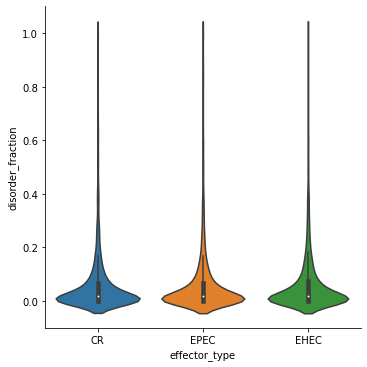

In [15]:
sns.catplot(
    x='effector_type',
    y='disorder_fraction',
    data=final_df[final_df['collection_type']=='Reference'],
    kind='violin')